In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
df = pd.read_excel("premiums_young_with_gr.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [3]:
df.shape

(20096, 14)

In [4]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4


In [5]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [10]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1], dtype=int64)

In [11]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [12]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns 

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

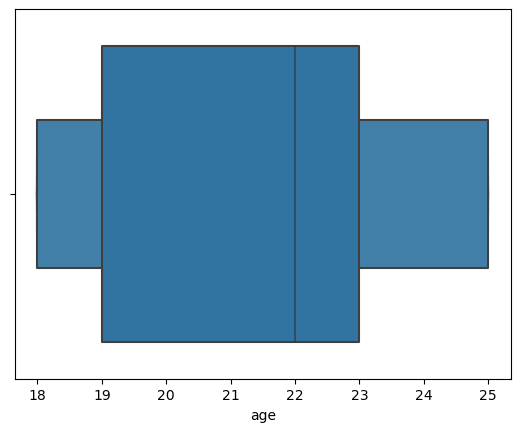

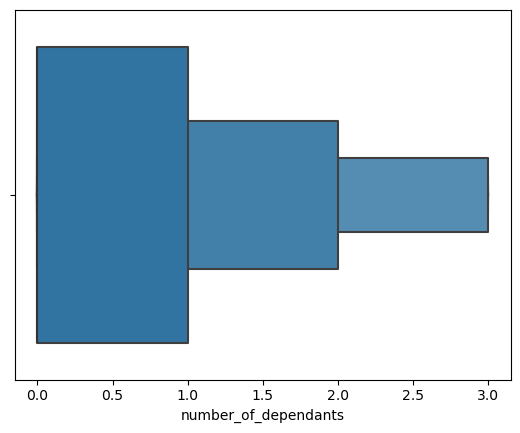

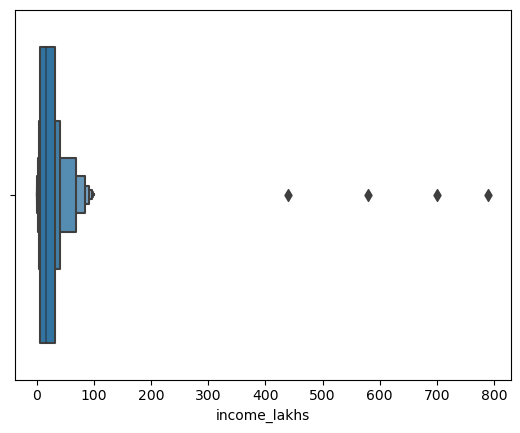

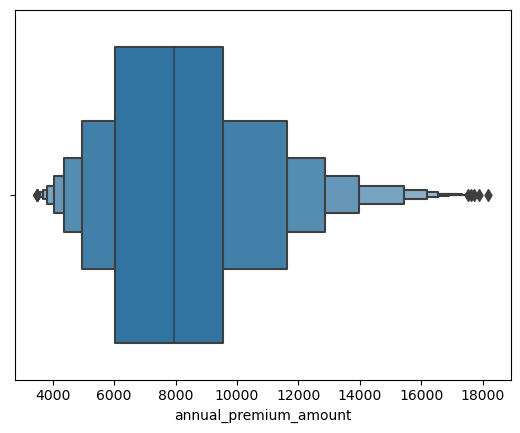

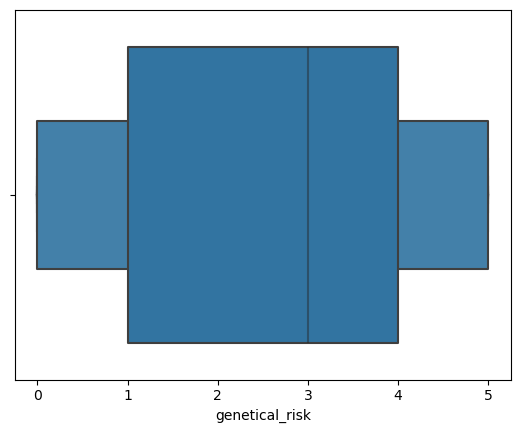

In [13]:
for col in numeric_columns:
    sns.boxenplot(x=df[col])
    plt.show()

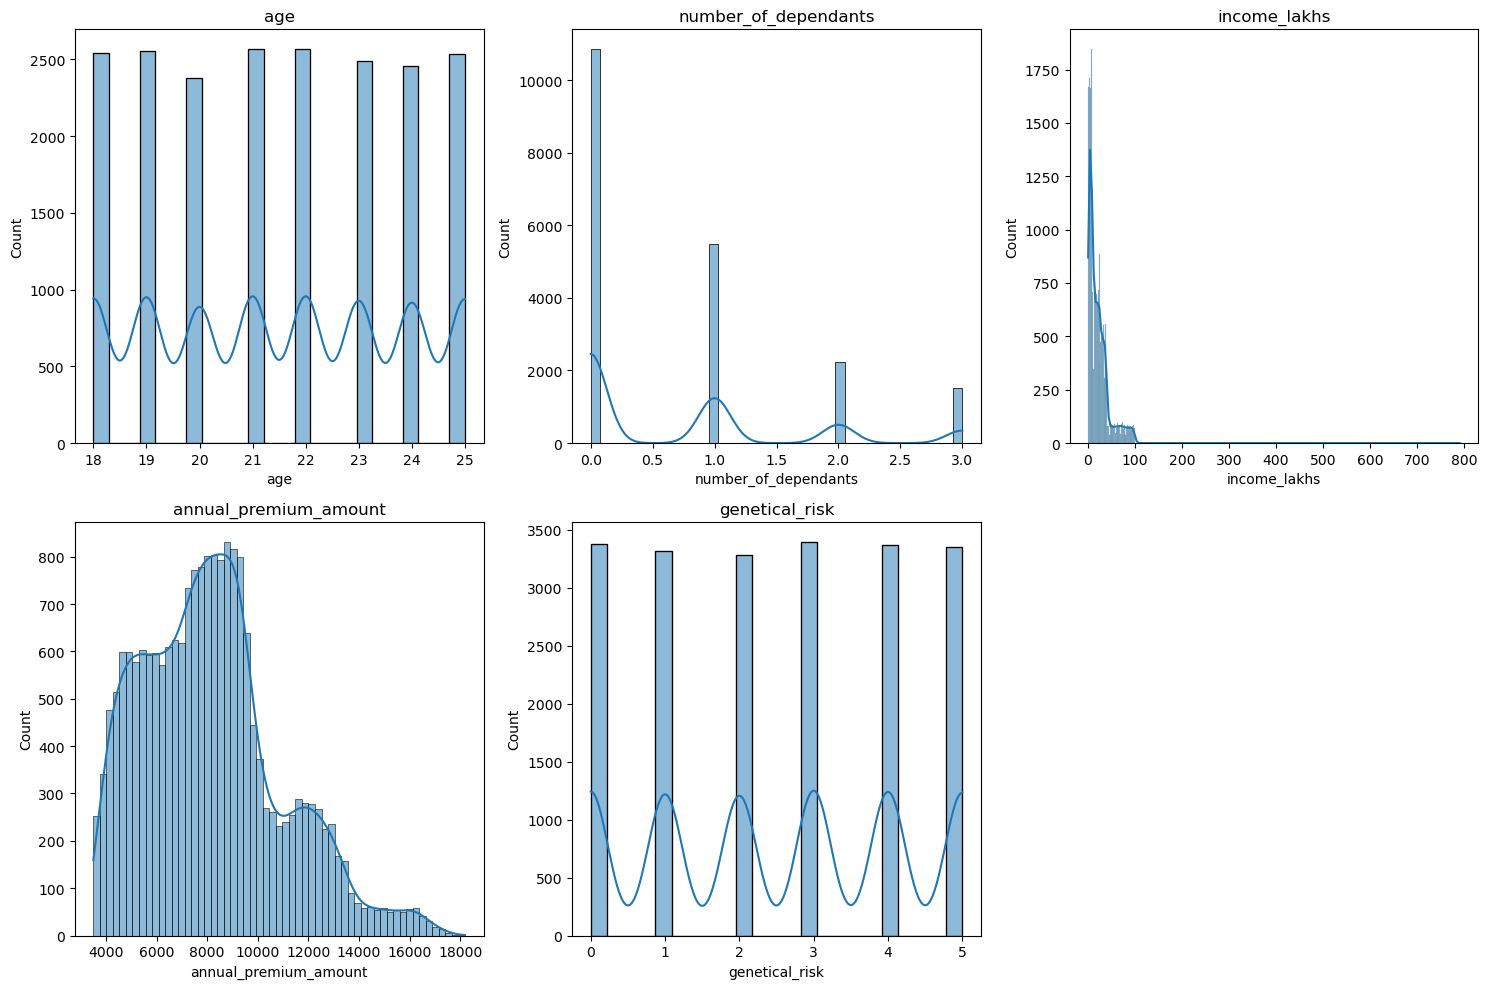

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the size to ensure plots are not squeezed

for i, column in enumerate(numeric_columns):
    # Locating the correct subplot using integer division and modulus
    ax = axs[i // 3, i % 3]  # Row index is i//3, column index is i%3
    sns.histplot(df[column], kde=True, ax=ax)
    ax.set_title(column)

# If the last subplot axis is unused, you can turn it off
if len(numeric_columns) % 3 != 0:
    for j in range(len(numeric_columns), 6):  # This will disable any unused subplots
        axs.flat[j].set_visible(False)

plt.tight_layout()
plt.show()

In [16]:
df[df['age']>100]['age'].unique()

array([], dtype=int64)

In [17]:
df1=df[df.age<=100]
df1.age.describe()

count    20090.000000
mean        21.494375
std          2.294052
min         18.000000
25%         19.000000
50%         22.000000
75%         23.000000
max         25.000000
Name: age, dtype: float64

In [18]:
def get_iqr_bounds(col):
    Q1, Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    return lower_bound, upper_bound
lower, upper = get_iqr_bounds(df1['income_lakhs'])
lower, upper

(-31.5, 68.5)

In [19]:
df1[df1.income_lakhs>upper].shape

(1295, 14)

In [20]:
quantile_thresold = df1.income_lakhs.quantile(0.999)
quantile_thresold

100.0

In [21]:
df1[df1.income_lakhs>quantile_thresold].shape

(4, 14)

In [22]:
df2 = df1[df1.income_lakhs<quantile_thresold].copy()
df2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20091,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,91,No Disease,Gold,11603,1
20092,23,Female,Northwest,Unmarried,0,Obesity,Occasional,Freelancer,> 40L,57,Diabetes,Gold,14498,2
20093,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111,5
20094,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564,4


IndexError: index 2 is out of bounds for axis 0 with size 2

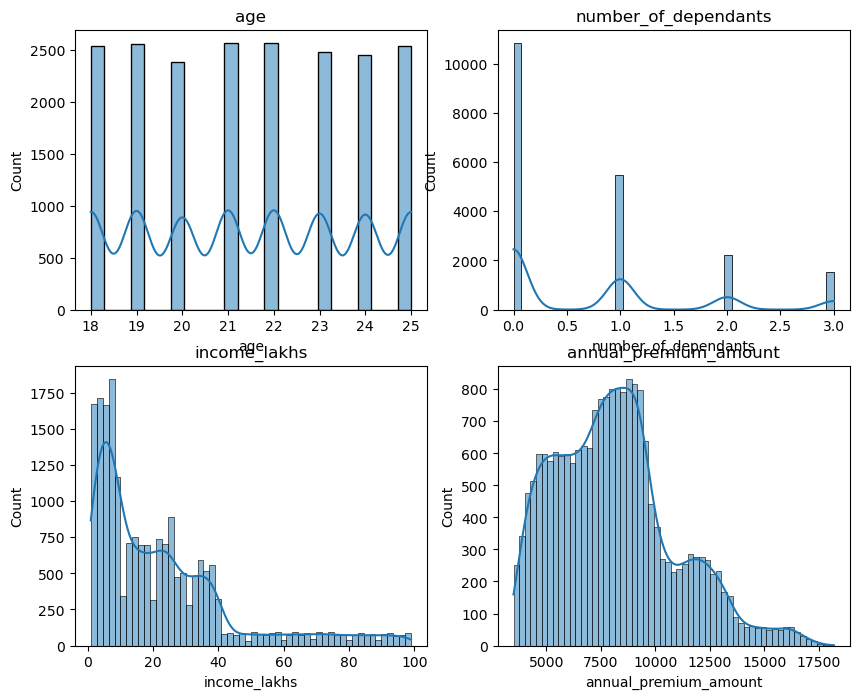

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Adjust the size as necessary

for i, column in enumerate(numeric_columns):
    ax = axs[i//2, i%2]  # Determines the position of the subplot in the grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

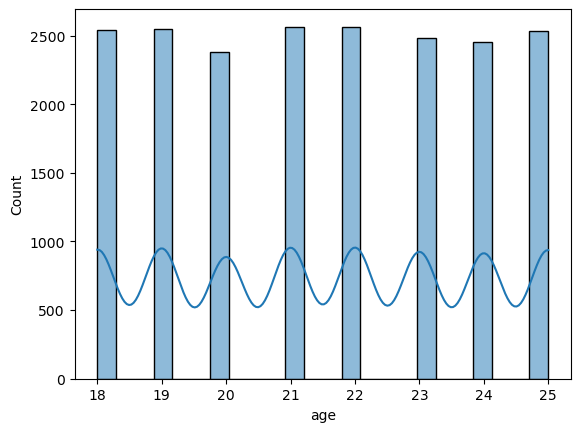

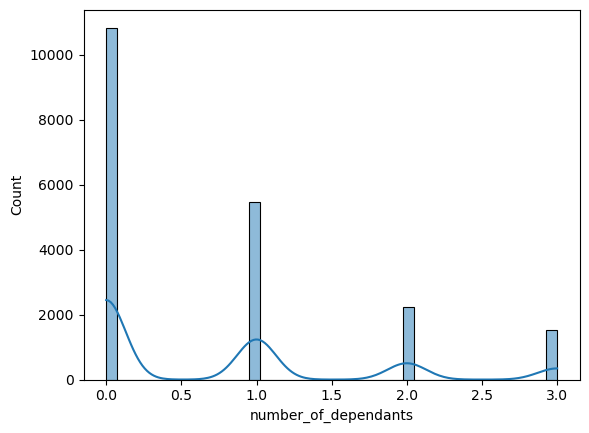

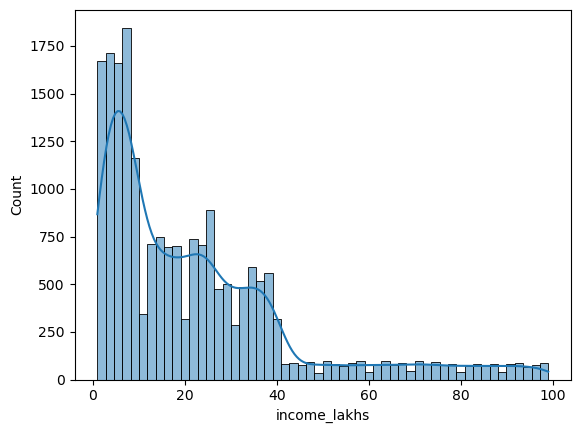

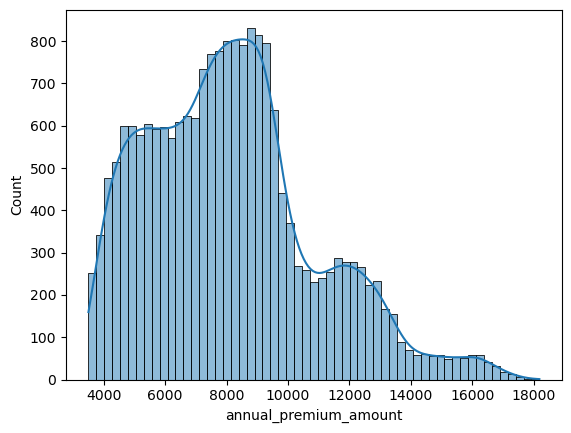

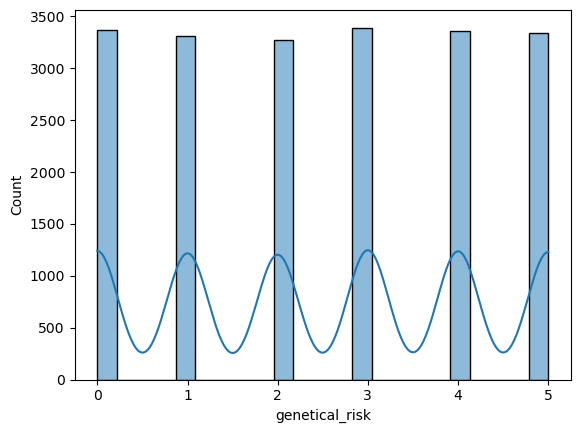

In [24]:
for col in numeric_columns:
    sns.histplot(df2[col], kde=True)
    plt.show()

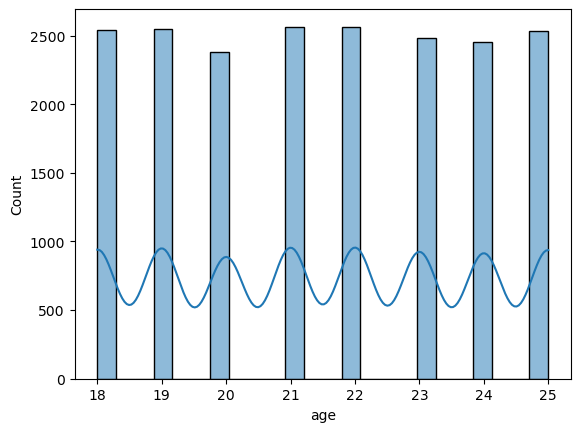

In [25]:
sns.histplot(df2['age'], kde=True)
plt.show()

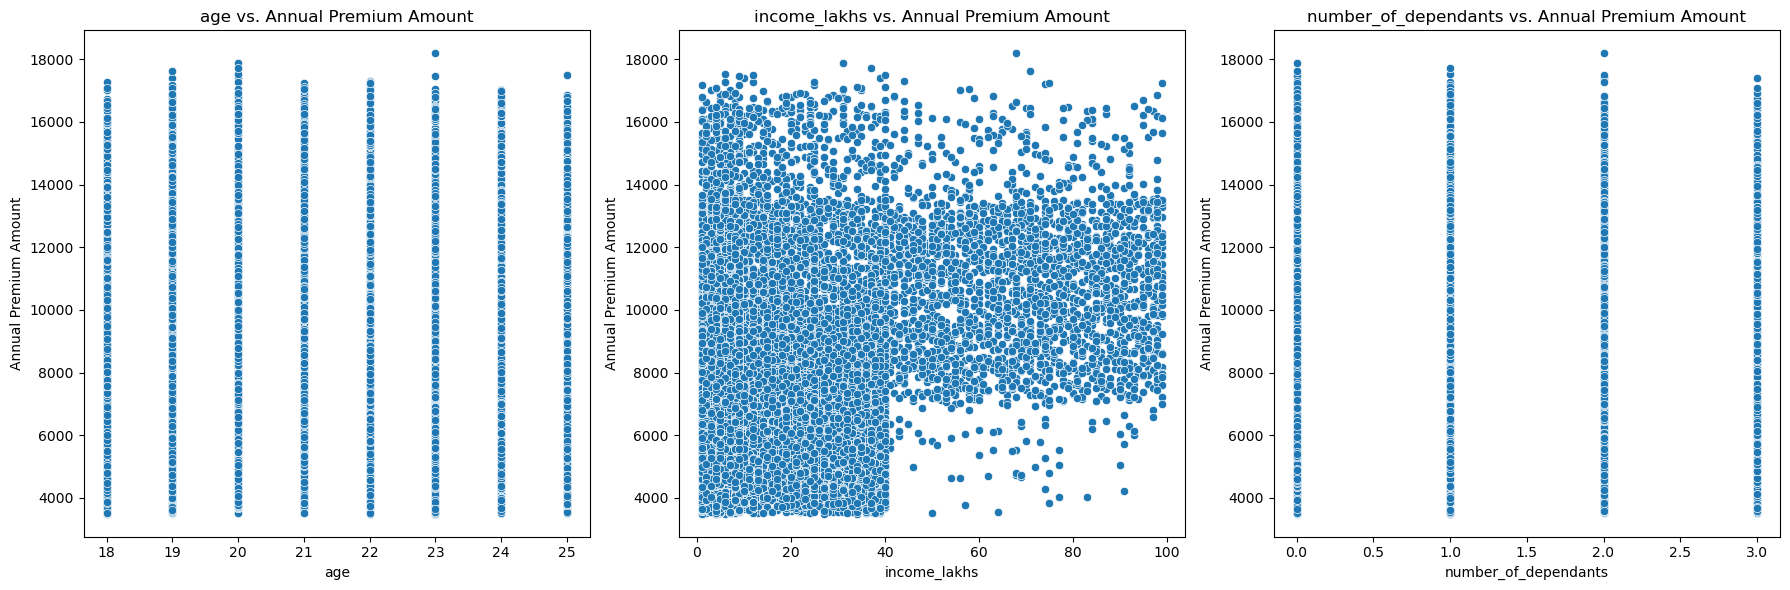

In [26]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

<AxesSubplot:xlabel='age', ylabel='annual_premium_amount'>

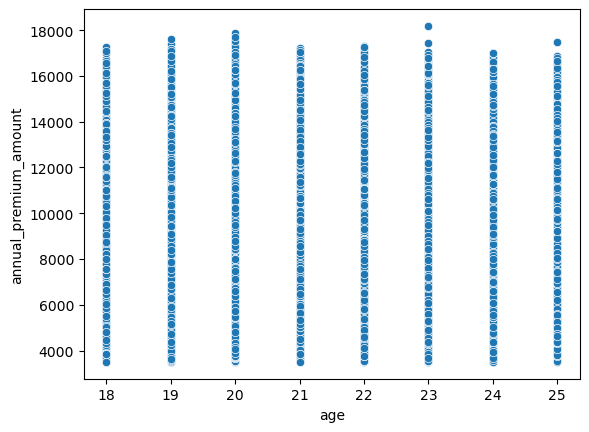

In [27]:
sns.scatterplot(data=df2, x='age', y='annual_premium_amount')

<AxesSubplot:xlabel='age', ylabel='income_lakhs'>

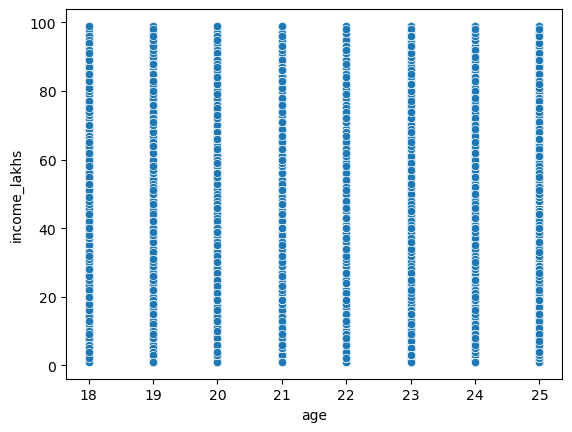

In [28]:
sns.scatterplot(data=df2, x='age', y='income_lakhs')

In [29]:
df2.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4


In [30]:
categorical_cols= ['gender','region','marital_status','bmi_category','smoking_status','employment_status','medical_history','medical_history','insurance_plan']
for col in categorical_cols:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [31]:
df2['smoking_status'].replace({'Smoking=0':'No Smoking','Does Not Smoke':'No Smoking',
                              'Not Smoking':'No Smoking'},
                               inplace=True)
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [32]:
pct_count=df2['gender'].value_counts(normalize=True)
pct_count

Male      0.550364
Female    0.449636
Name: gender, dtype: float64

In [33]:
pct_count.values

array([0.55036402, 0.44963598])

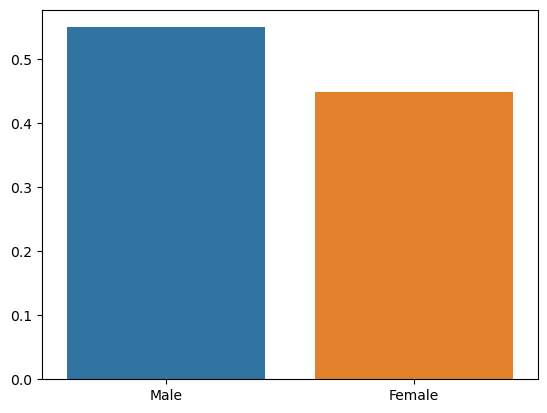

In [34]:
sns.barplot(x=pct_count.index, y=pct_count.values)
plt.show()

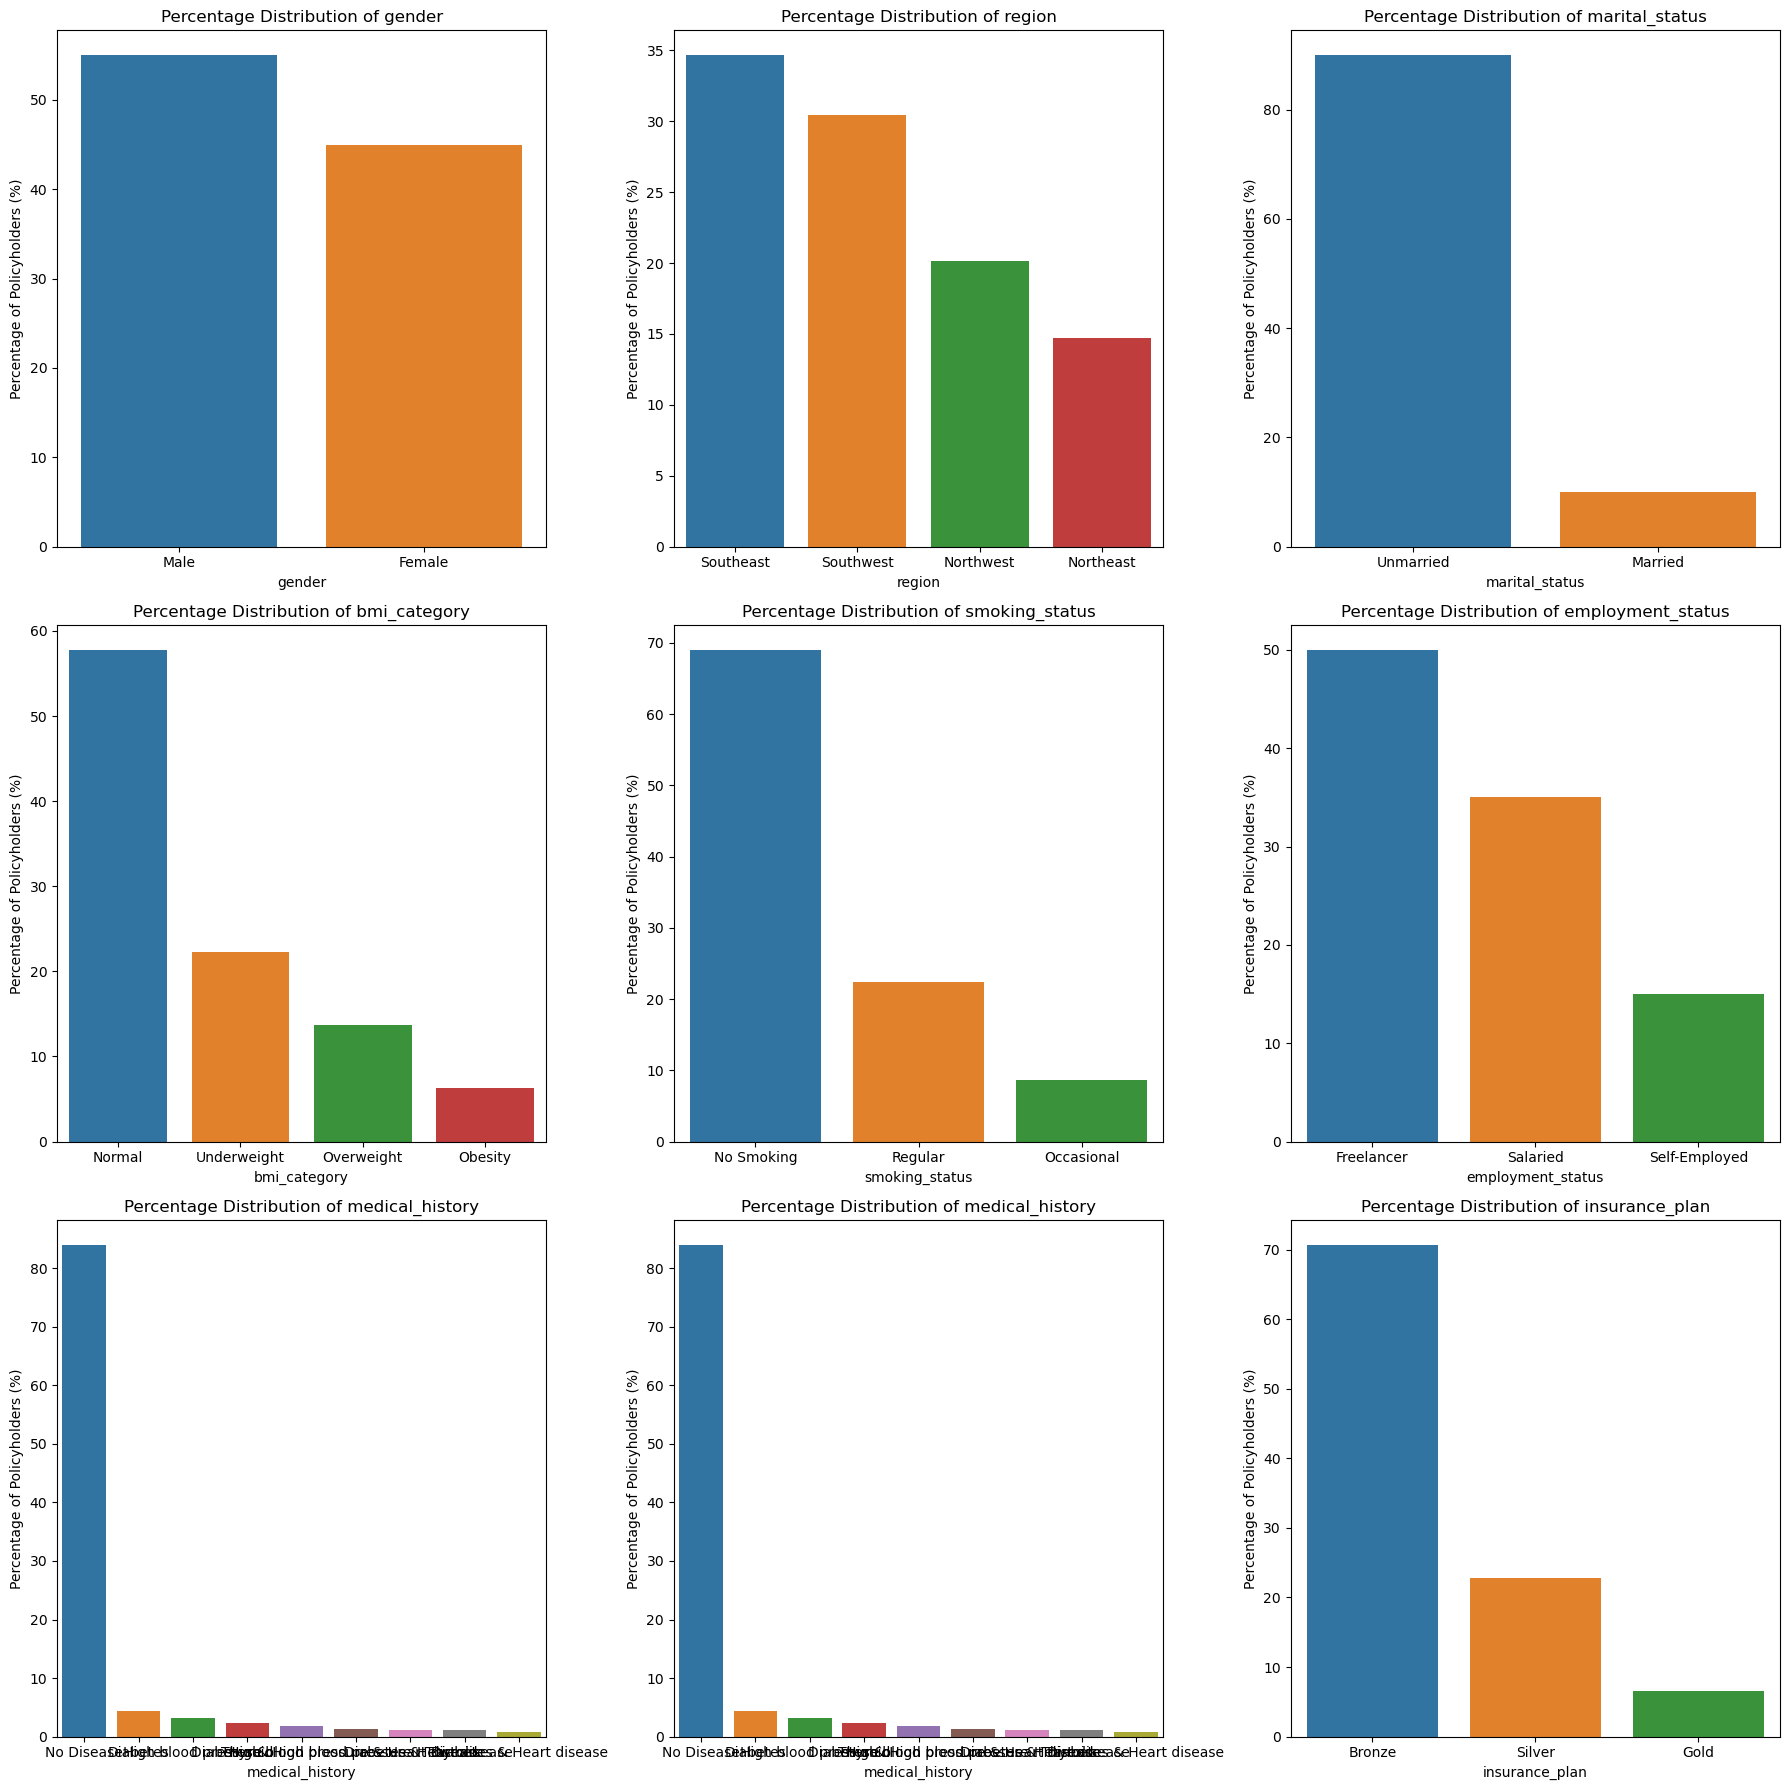

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

In [36]:
cross_tab=pd.crosstab(df2['income_level'], df2['insurance_plan'])
cross_tab


insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,362,1995


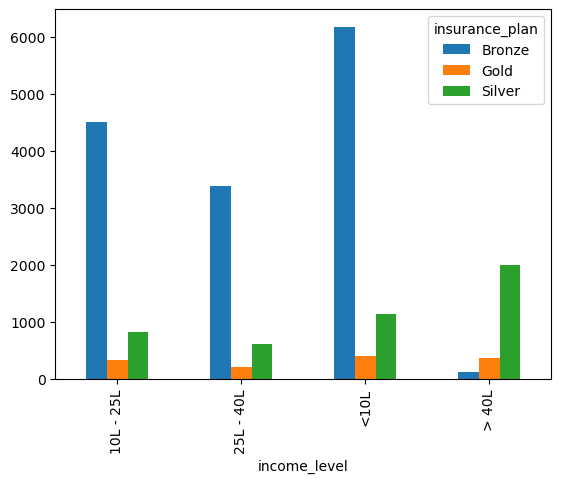

In [37]:
cross_tab.plot(kind="bar")
plt.show()

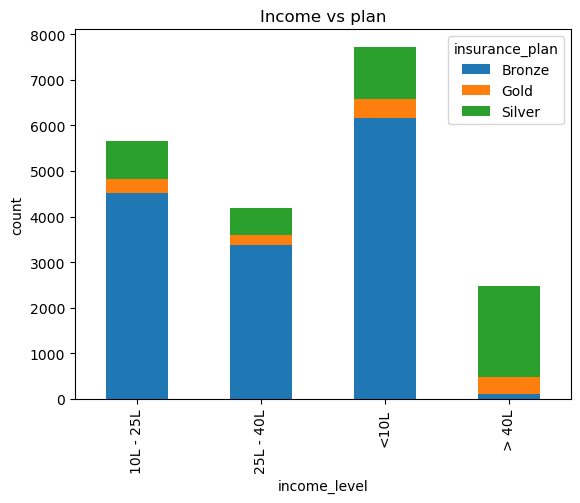

In [38]:
cross_tab.plot(kind="bar",stacked=True)
plt.title('Income vs plan')
plt.ylabel('count')
plt.show()

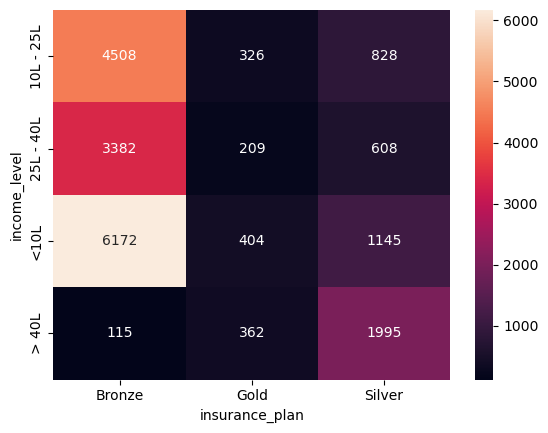

In [39]:
sns.heatmap(cross_tab, annot=True,fmt='d')
plt.show()


In [40]:
 df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


In [41]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [42]:
risk_scores = {  "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0}


In [43]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,no disease,none,0,0.000000


In [44]:
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [45]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [46]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [47]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,1,no disease,none,0,0.000000


In [48]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [49]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20054 entries, 0 to 20095
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20054 non-null  int64  
 1   number_of_dependants             20054 non-null  int64  
 2   income_level                     20054 non-null  int64  
 3   income_lakhs                     20054 non-null  int64  
 4   medical_history                  20054 non-null  object 
 5   insurance_plan                   20054 non-null  int64  
 6   annual_premium_amount            20054 non-null  int64  
 7   genetical_risk                   20054 non-null  int64  
 8   disease1                         20054 non-null  object 
 9   disease2                         20054 non-null  object 
 10  total_risk_score                 20054 non-null  int64  
 11  normalized_risk_score            20054 non-null  float64
 12  gender_Male       

In [50]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)  

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


In [51]:
df4.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

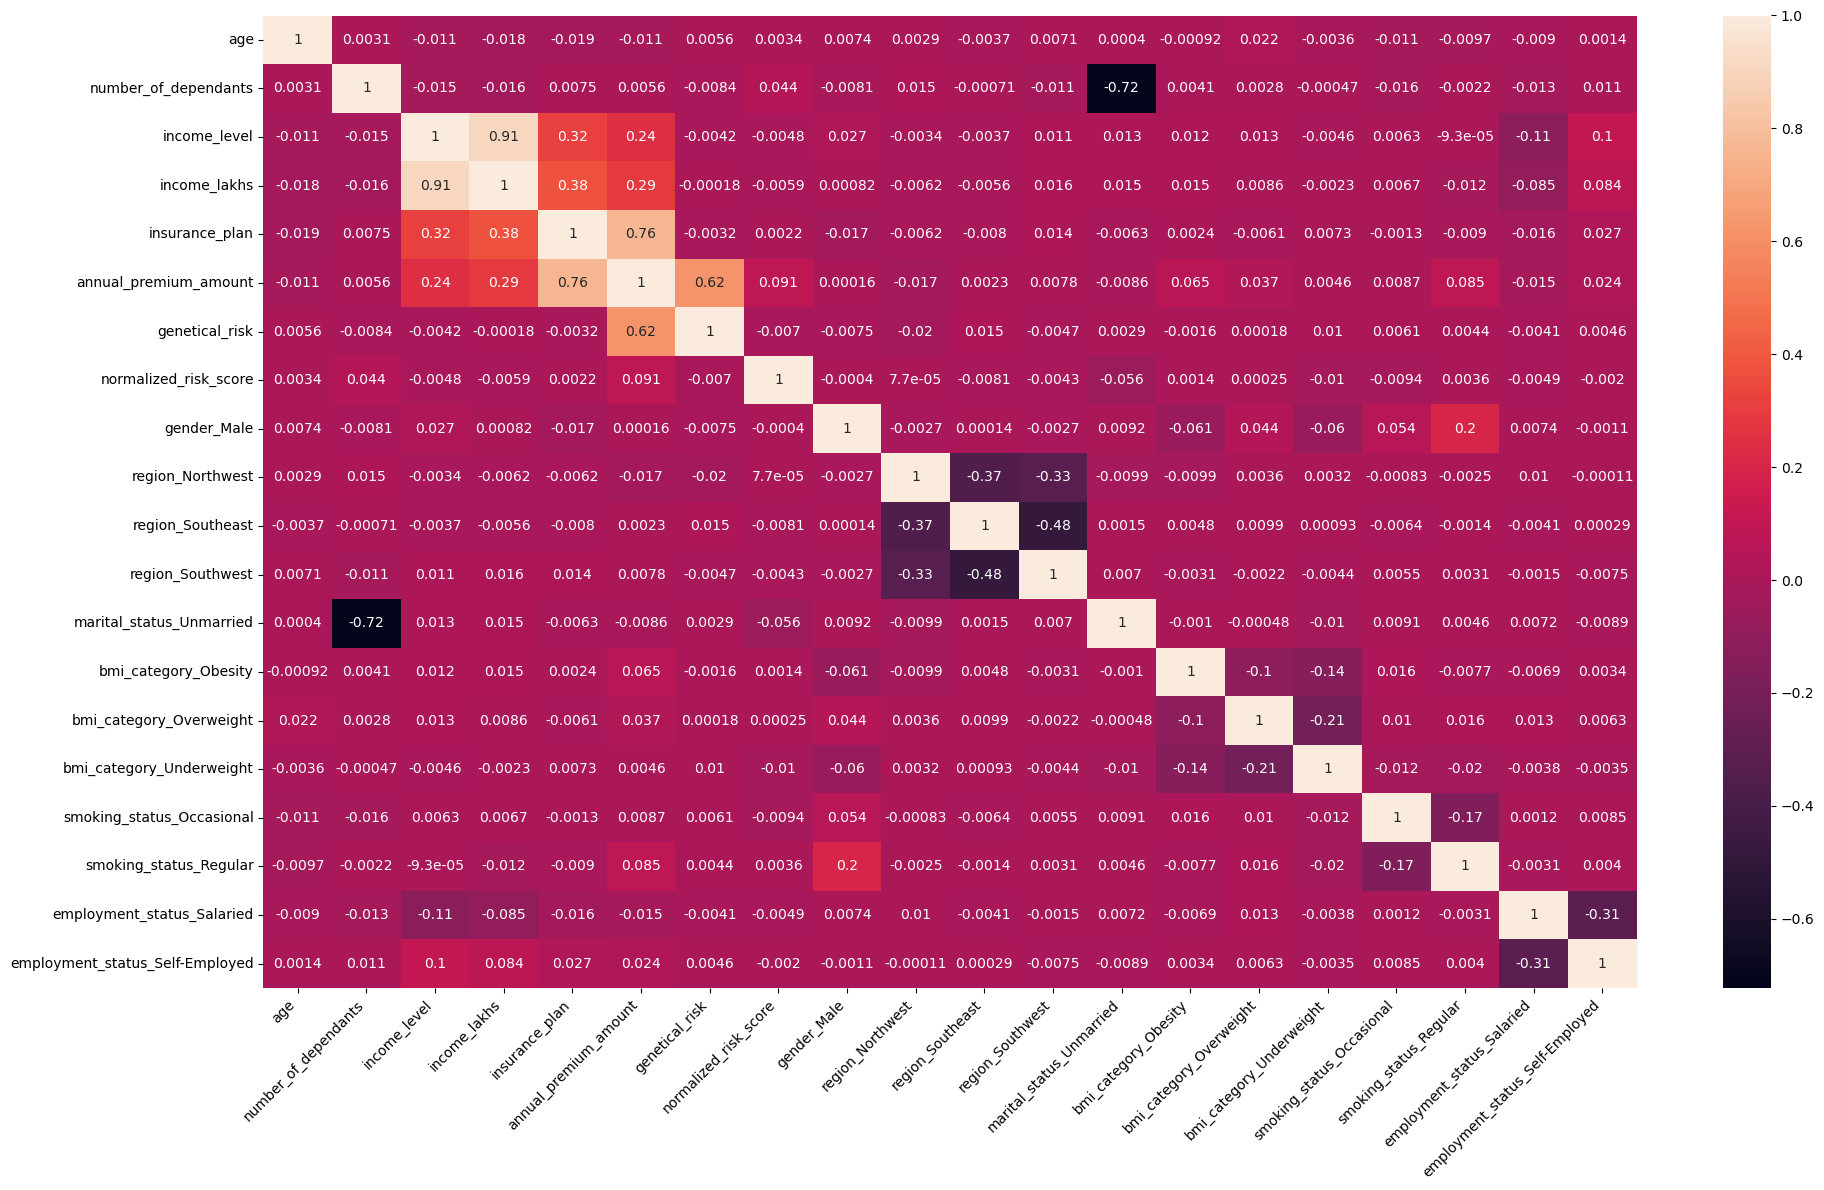

In [52]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [53]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [54]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000,20054.000000
mean,0.499145,0.240816,0.356970,0.217005,0.178967,2.503241,0.092130,0.550364,0.201306,0.346863,0.304578,0.899920,0.063528,0.136531,0.222300,0.086417,0.223497,0.350155,0.149945
std,0.327769,0.312344,0.346809,0.219663,0.299827,1.710238,0.230059,0.497469,0.400987,0.475984,0.460240,0.300114,0.243917,0.343360,0.415802,0.280985,0.416599,0.477030,0.357027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.051020,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.428571,0.000000,0.333333,0.153061,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.306122,0.500000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [56]:
calculate_vif(X)

,Column,VIF
0,age,3.154003
1,number_of_dependants,1.929843
2,income_level,12.076236
3,income_lakhs,12.066070
4,insurance_plan,1.587040
5,genetical_risk,2.979519
6,normalized_risk_score,1.154598
7,gender_Male,2.311741
8,region_Northwest,2.153798
9,region_Southeast,2.988985


In [57]:
calculate_vif(X.drop('income_level', axis = 'columns'))

,Column,VIF
0,age,3.152594
1,number_of_dependants,1.927345
2,income_lakhs,2.295899
3,insurance_plan,1.581741
4,genetical_risk,2.979517
5,normalized_risk_score,1.154563
6,gender_Male,2.301517
7,region_Northwest,2.152910
8,region_Southeast,2.987812
9,region_Southwest,2.743533


In [58]:
X_reduced=X.drop('income_level', axis='columns')
X_reduced

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.5,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020408,0.5,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.979592,0.5,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.142857,0.0,2,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.132653,0.0,1,0.000000,1,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20091,0.000000,0.000000,0.918367,1.0,1,0.000000,0,0,1,0,1,0,0,1,0,0,0,0
20092,0.714286,0.000000,0.571429,1.0,2,0.428571,0,1,0,0,1,1,0,0,1,0,0,0
20093,0.857143,0.000000,0.346939,0.0,5,0.000000,0,1,0,0,1,0,0,1,0,0,0,1
20094,0.428571,0.000000,0.316327,0.0,4,0.000000,1,1,0,0,1,0,0,0,0,1,0,0


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14037, 18)
x test:  (6017, 18)
y train:  (14037,)
y test:  (6017,)


In [60]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.9884613429334488, 0.9883024425745823)

In [61]:
model_lr.coef_

array([-6.07009916e+00,  5.05214522e+00, -7.45274752e+00,  7.00494096e+03,
        9.98218492e+02,  1.11479443e+03,  4.93797939e+00,  6.51640518e+00,
       -3.84458025e+00,  5.55789282e+00, -2.91905776e+00,  8.10591557e+02,
        4.07171235e+02,  1.10207314e+02,  2.00886429e+02,  6.12475040e+02,
       -1.25939895e+00, -7.52704515e+00])

In [62]:
model_lr.intercept_

3997.399023656868

In [63]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  88813.451407234 RMSE:  298.0158576439079


In [64]:
X_test.shape

(6017, 18)

In [65]:
y_test.shape

(6017,)

In [66]:
X_train.shape

(14037, 18)

In [67]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([  -6.070099,    5.052145,   -7.452748, 7004.940961,  998.218492,
       1114.794435,    4.937979,    6.516405,   -3.84458 ,    5.557893,
         -2.919058,  810.591557,  407.171235,  110.207314,  200.886429,
        612.47504 ,   -1.259399,   -7.527045])

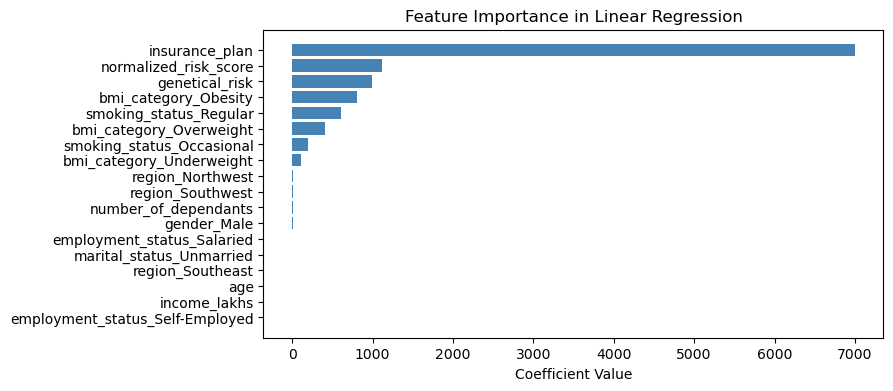

In [68]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [69]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9884608826630058, 0.9883047751298741)

In [70]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score = model_xgb.score(X_train, y_train)
train_score, test_score

(0.9925925390353109, 0.987472113639224)

In [71]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBOOST Regression ==> MSE: ", mse_xgb, "RMSE: ", rmse_xgb)

XGBOOST Regression ==> MSE:  95117.70586570942 RMSE:  308.4115851677907


In [72]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9880211426647674

In [73]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [74]:
best_model = random_search.best_estimator_

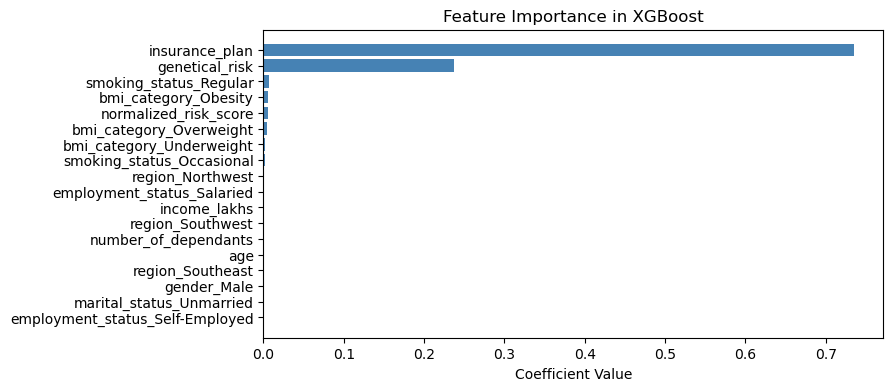

In [75]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

### error analysis

In [76]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
1710,4096,4424.137695,328.137695,8.011174
11963,4503,4424.137695,-78.862305,-1.751328
8719,8332,8172.020508,-159.979492,-1.920061
7208,11578,11518.022461,-59.977539,-0.518030
9416,7045,7038.253418,-6.746582,-0.095764


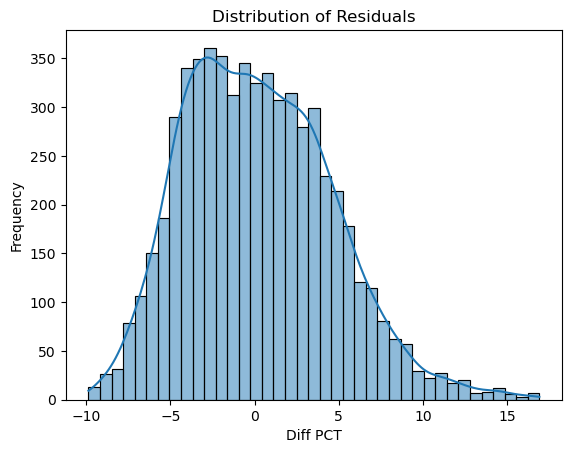

In [77]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [78]:
results_df[np.abs(results_df.diff_pct)>10]

,actual,predicted,diff,diff_pct
1835,4518,5071.386230,553.386230,12.248478
12285,3532,4092.481934,560.481934,15.868684
14769,3687,4092.481934,405.481934,10.997611
1812,4138,4662.225098,524.225098,12.668562
7758,3710,4145.879883,435.879883,11.748784
...,...,...,...,...
7722,4926,5469.675781,543.675781,11.036861
7991,3624,4145.879883,521.879883,14.400659
10165,3501,4092.481934,591.481934,16.894657
18017,4906,5469.675781,563.675781,11.489519


In [79]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,diff,diff_pct
1835,4518,5071.386230,553.386230,12.248478
12285,3532,4092.481934,560.481934,15.868684
14769,3687,4092.481934,405.481934,10.997611
1812,4138,4662.225098,524.225098,12.668562
7758,3710,4145.879883,435.879883,11.748784


In [80]:
extreme_results_df.shape

(130, 4)

In [81]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

2.160545122153897

In [82]:
results_df[np.abs(results_df.diff_pct)>50]

,actual,predicted,diff,diff_pct


In [83]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct


In [84]:
extreme_results_df.index

Int64Index([ 1835, 12285, 14769,  1812,  7758, 16580,  7639, 14074,  4226,
             3396,
            ...
             1557,  7912, 11997, 11302,   711,  7722,  7991, 10165, 18017,
            18574],
           dtype='int64', length=130)

In [85]:
X_test.index

Int64Index([ 1710, 11963,  8719,  7208,  9416, 15637,  6511, 11179,  7608,
             6396,
            ...
            18017, 17253,  5619, 20068,  3065,  2154, 11201, 18574, 17354,
            10020],
           dtype='int64', length=6017)

In [86]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
1835,0.714286,0.000000,0.030612,0.0,1,0.0,1,0,0,1,1,0,0,0,0,0,0,0
12285,0.428571,0.333333,0.234694,0.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0
14769,0.428571,0.666667,0.071429,0.0,0,0.0,0,0,1,0,1,0,0,0,0,0,1,0
1812,0.714286,0.000000,0.336735,0.0,0,0.0,1,0,1,0,1,0,0,0,0,1,0,0
7758,0.142857,1.000000,0.030612,0.0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0


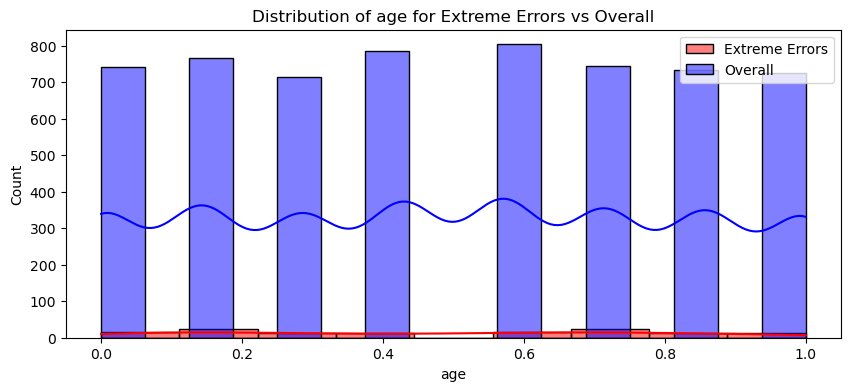

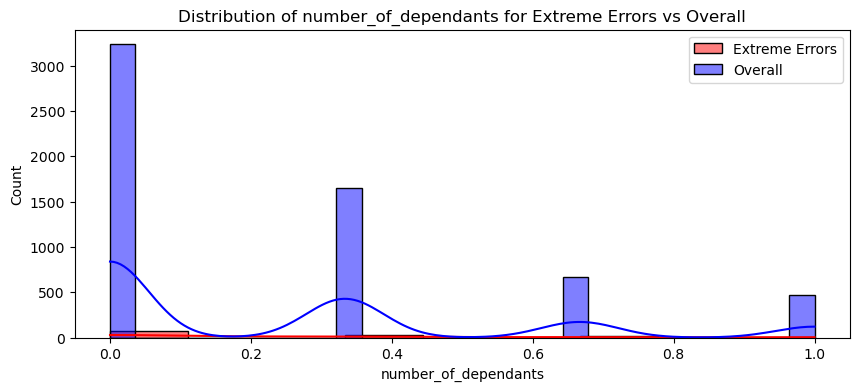

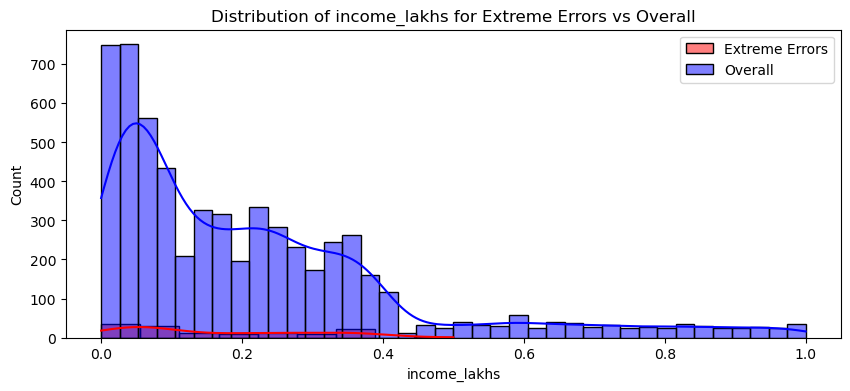

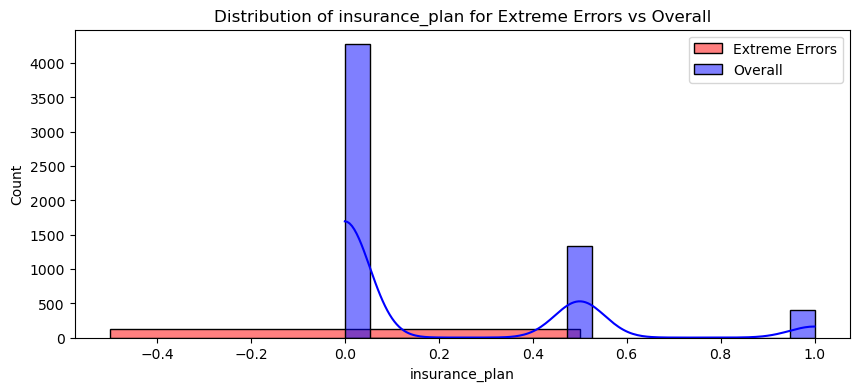

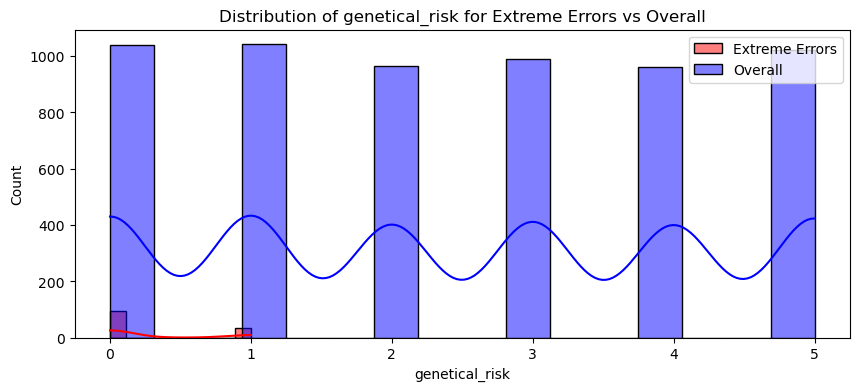

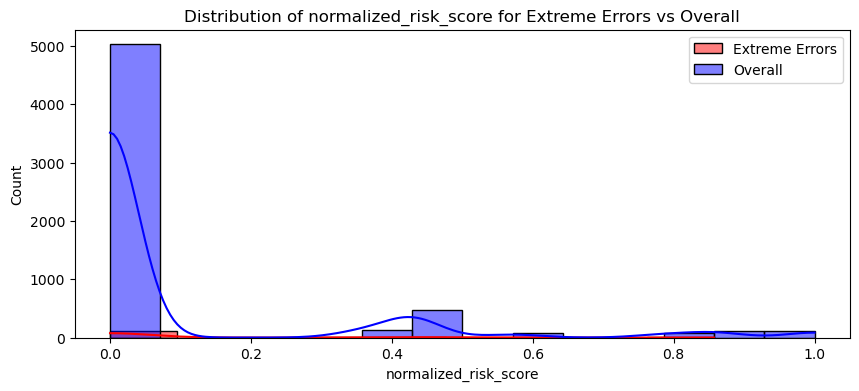

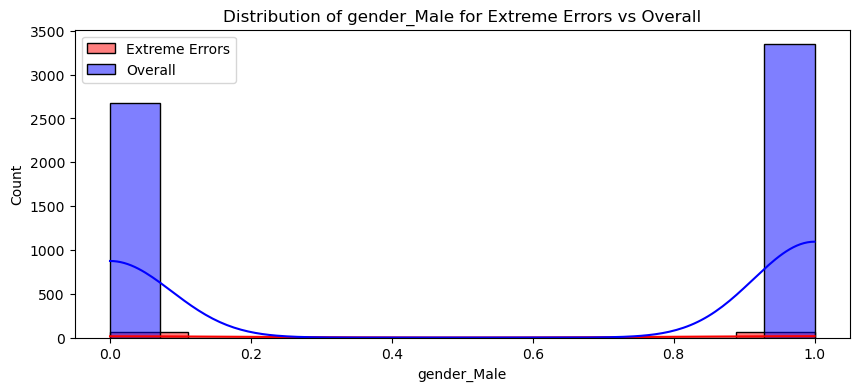

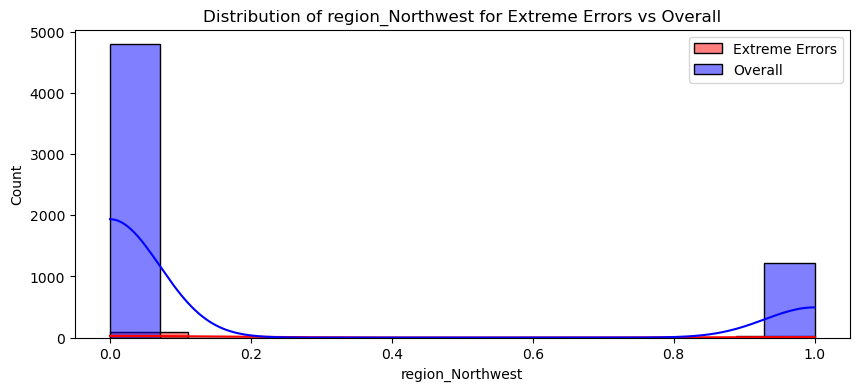

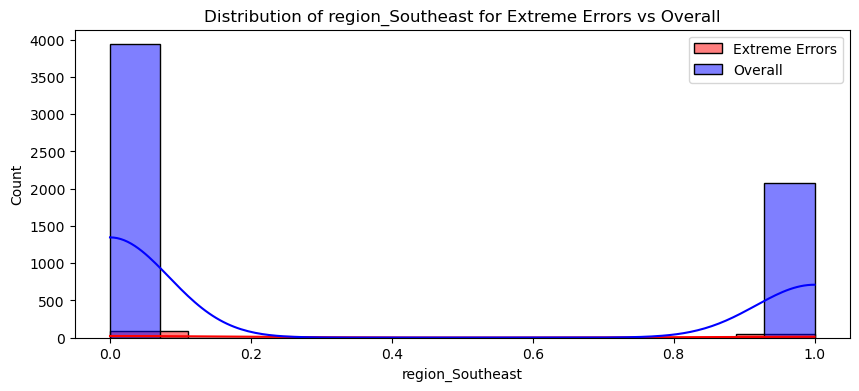

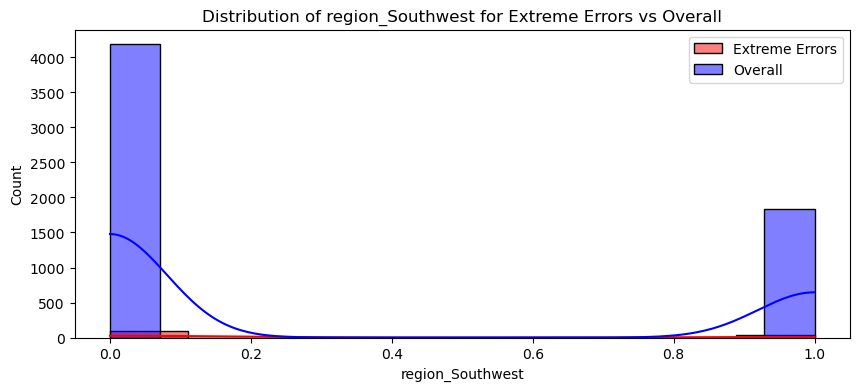

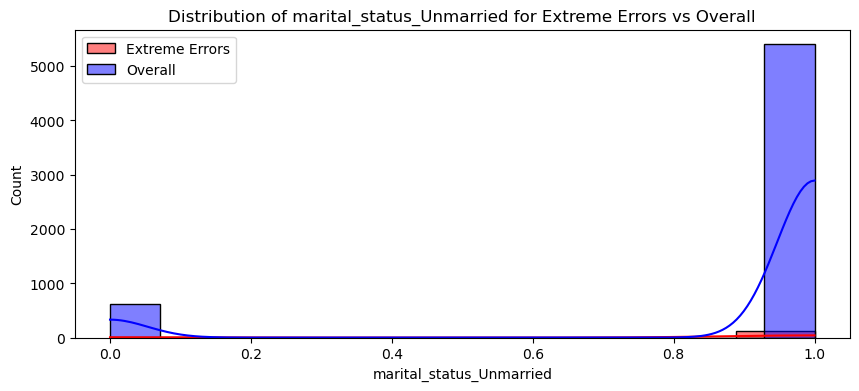

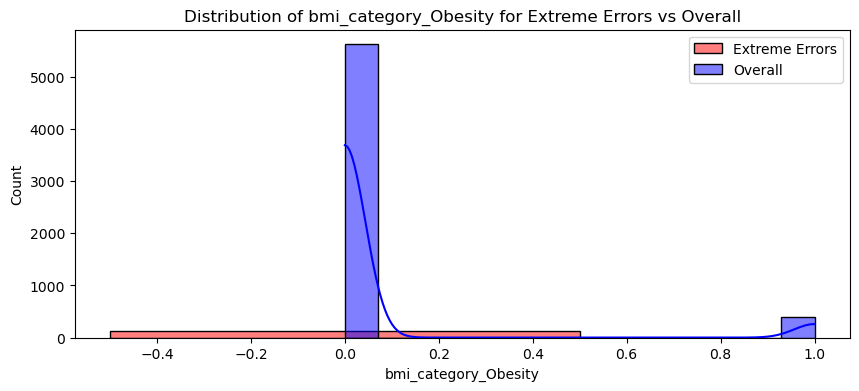

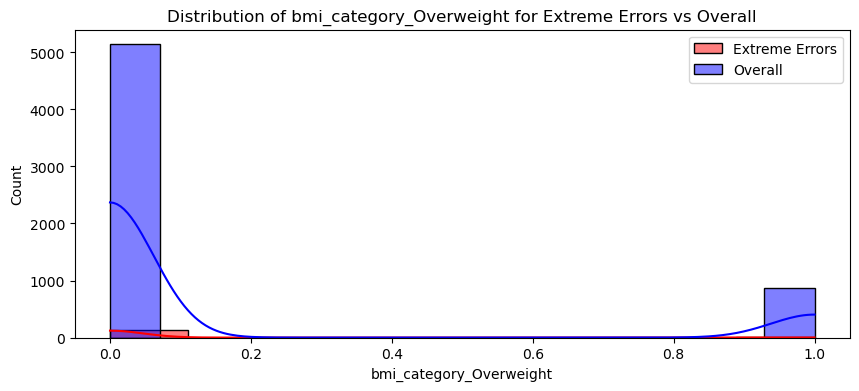

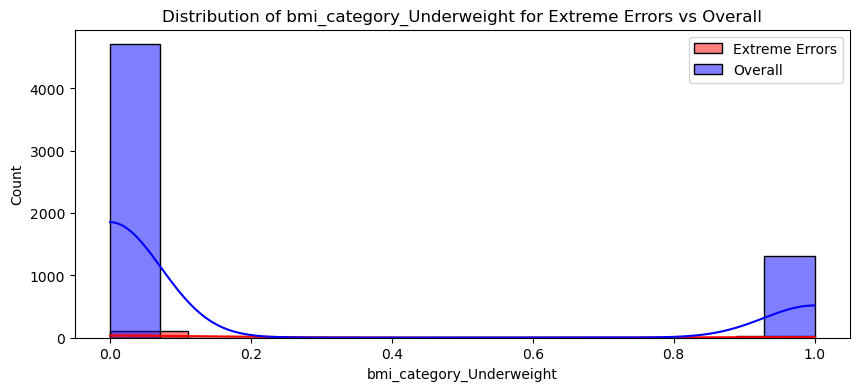

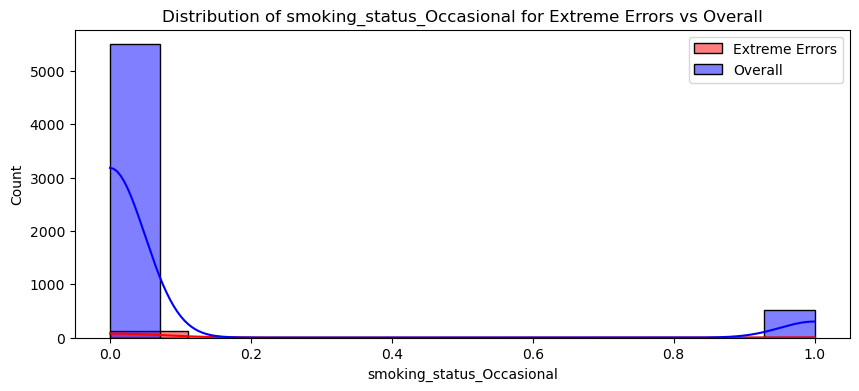

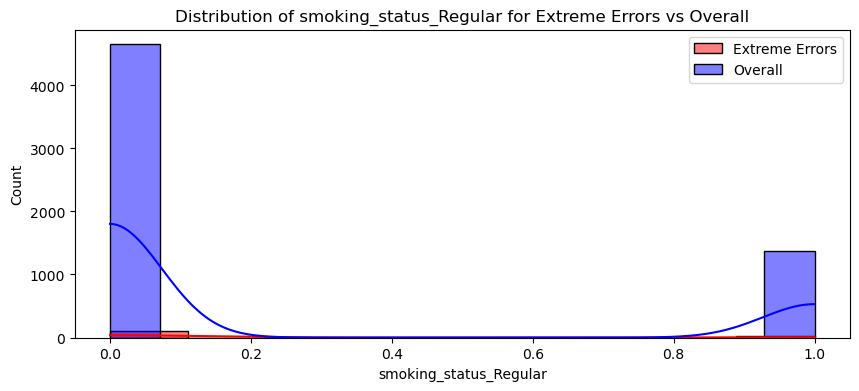

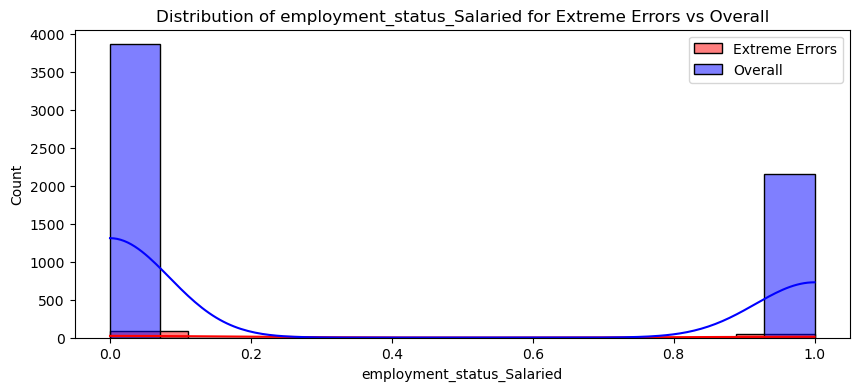

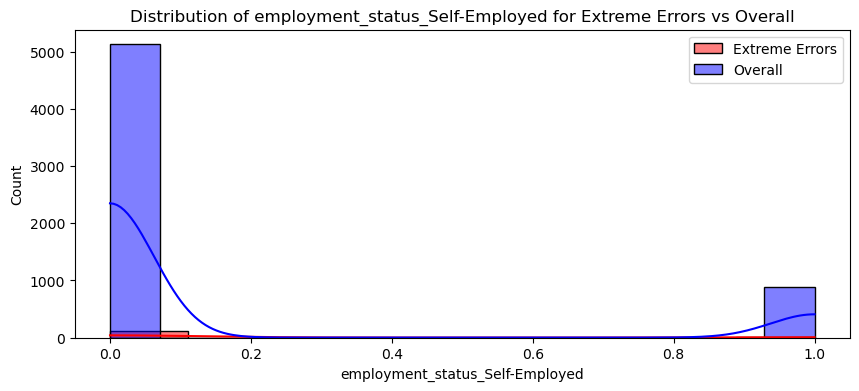

In [87]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

In [88]:
extreme_errors_df['income_level']=-1

In [89]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,0.0,-2.0,4.0,1.0
1,21.0,1.0,-2.0,24.0,1.0
2,21.0,2.0,-2.0,8.0,1.0
3,23.0,0.0,-2.0,34.0,1.0
4,19.0,3.0,-2.0,4.0,1.0


In [90]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,130.000000,130.000000,130.0,130.000000,130.0
mean,21.323077,0.676923,-2.0,16.776923,1.0
std,2.248911,0.941839,0.0,12.752422,0.0
min,18.000000,0.000000,-2.0,1.000000,1.0
25%,19.000000,0.000000,-2.0,6.000000,1.0
50%,21.500000,0.000000,-2.0,11.500000,1.0
75%,23.000000,1.000000,-2.0,28.500000,1.0
max,25.000000,3.000000,-2.0,50.000000,1.0


<AxesSubplot:xlabel='age', ylabel='Count'>

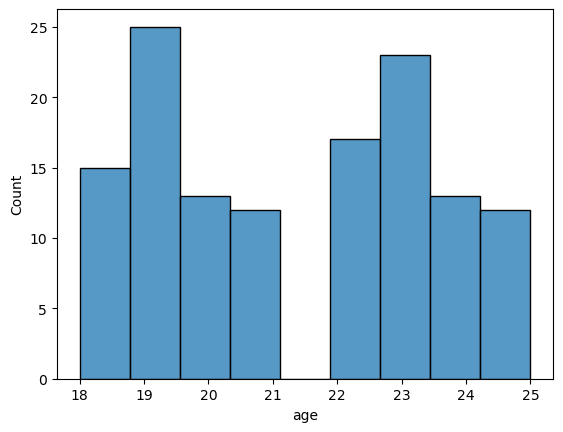

In [91]:
sns.histplot(df_reversed.age)

### Export the model

In [ ]:
pip install joblib

In [92]:
from joblib import dump

In [94]:
dump(best_model, "artifacts/model_young.joblib")

['artifacts/model_young.joblib']

In [96]:
scaler_with_cols={
    'scaler':scaler,
    'cols_to_scale':cols_to_scale
}
scaler_with_cols

{'scaler': MinMaxScaler(),
 'cols_to_scale': ['age',
  'number_of_dependants',
  'income_level',
  'income_lakhs',
  'insurance_plan']}

In [97]:
dump(scaler_with_cols, "artifacts/scaler_young.joblib")

['artifacts/scaler_young.joblib']